### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint
from tqdm import tqdm

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

In [3]:
from pydantic import BaseModel
from typing import Any

#### set up paths

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

In [5]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "1999-03-01T00:00:00Z"
HRU_id = 1620500
alpha = 1.26

In [6]:
from ewatercycle.forcing import sources

In [7]:
camels_forcing = sources.HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'0{HRU_id}_lump_cida_forcing_leap.txt',
                          alpha = alpha,
                          )

#### import model

In [8]:
# from ewatercycle.models import HBV

In [9]:
from ewatercycle_DA.local_models.HBV import HBVLocal

In [10]:
truth_model = HBVLocal(forcing=camels_forcing)

In [11]:
truth_parameters = np.array([3.2,   0.9,  700,    1.2,   .16,   4,     .08,  .0075, 0.5])
truth_initial_storage = np.array([20,  10,  50,  100, 10])

In [12]:
config_file, _ = truth_model.setup(
            parameters=','.join([str(p) for p in truth_parameters]),
            initial_storage=','.join([str(s) for s in truth_initial_storage]),
           )

In [13]:
truth_model.initialize(config_file)

In [14]:
Q_m = []
time = []
while truth_model.time < truth_model.end_time:
    truth_model.update()
    Q_m.append(truth_model.get_value("Q"))
    time.append(truth_model.time_as_datetime.date())
truth_model.finalize()

In [15]:
truth = pd.DataFrame(Q_m, columns=["Q_m"],index=time)

In [16]:
rng = np.random.default_rng()  # Initiate a Random Number Generator
def add_normal_noise(like_sigma) -> float:
    """Normal (zero-mean) noise to be added to a state

    Args:
        like_sigma (float): scale parameter - pseudo variance & thus 'like'-sigma

    Returns:
        sample from normal distribution
    """
    return rng.normal(loc=0, scale=like_sigma)  # log normal so can't go to 0 ?

In [17]:
truth['Q'] = truth.apply(lambda x: x.Q_m + add_normal_noise(0.05) , axis=1)
truth.index = truth.apply(lambda x: pd.Timestamp(x.name),axis=1)
truth.index.name = "time"

<Axes: xlabel='time'>

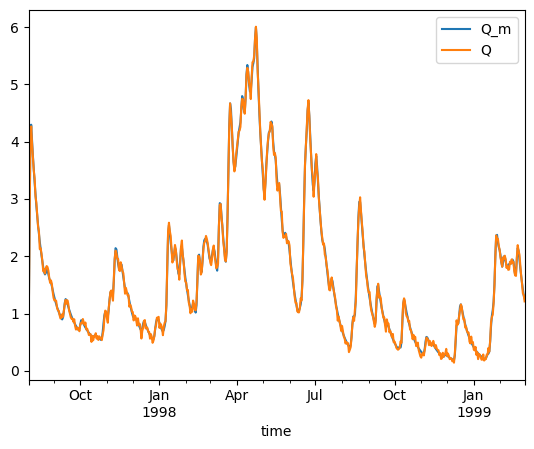

In [18]:
truth.plot()

In [19]:
ds_obs = xr.Dataset(data_vars=truth[['Q']])

In [20]:
current_time = str(datetime.now())[:-10].replace(":","_")
ds_obs_dir = observations_path / f'truth_model_HBV_{current_time}.nc'
if not ds_obs_dir.is_file():
    ds_obs.to_netcdf(ds_obs_dir)

#### import DA function:

In [21]:
from ewatercycle_DA import DA
from ewatercycle_DA.local_models.HBV import HBVLocal

In [22]:
# ## Array of initial storage terms - we keep these constant for now 
# ##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5, 0])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks, FM
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001, 6])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01, 0.1])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$", "FM"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage", "Snowpack storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks", "FM"]
stor_names = ["Si", "Su", "Sf", "Ss", "Sp"]

# # set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [23]:
def H(Z):
    if len(Z) == 15:
        return Z[-1] 
    else: 
        raise SyntaxWarning(f"Length of statevector should be 13 but is {len(Z)}")

In [24]:
def calc_NSE(Qo, Qm):
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)

In [25]:
units= {"Imax":"mm",
        "Ce": "-",
        "Sumax": "mm",
        "Beta": "-",
        "Pmax": "mm",
        "Tlag": "d",
        "Kf": "-",
        "Ks": "-",
        "FM":'mm/d/degC',
        "Si": "mm",
        "Su": "mm",
        "Sf": "mm",
        "Ss": "mm",
        "Sp": "mm",
        "Ei_dt": "mm/d",
        "Ea_dt": "mm/d",
        "Qs_dt": "mm/d",
        "Qf_dt": "mm/d",
        "Q_tot_dt": "mm/d",
        "Q": "mm/d"}

## Adjust perturbation amount 

In [26]:
n_iters = 5
perturbation_sigma_lst = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
m_vars = len(perturbation_sigma_lst)

In [27]:
store_df  = []
store_ds = []
for perturbation_sigma in perturbation_sigma_lst:
    lst_ds = []
    lst_df = []
    for i in range(n_iters):
        weight_sigma = 0.5
        n_particles = 10
        ensemble = DA.Ensemble(N=n_particles)
        ensemble.setup()
        
        array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
        p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)
        
        # values wihch you 
        setup_kwargs_lst = []
        for index in range(n_particles):
            setup_kwargs_lst.append({'parameters':','.join([str(p) for p in p_intial[index]]), 
                                    'initial_storage':','.join([str(s) for s in s_0]),
                                     })
        
        ensemble.loaded_models.update({'HBVLocal': HBVLocal})
        
        # this initializes the models for all ensemble members. 
        ensemble.initialize(model_name=["HBVLocal"]*n_particles,
                            forcing=[camels_forcing]*n_particles,
                            setup_kwargs=setup_kwargs_lst) 
        
        lst_like_sigma = [perturbation_sigma] * 14 + [0]
        hyper_parameters = {'like_sigma_weights' : weight_sigma,
                            'like_sigma_state_vector' : lst_like_sigma,
                           }
        
        ensemble.initialize_da_method(ensemble_method_name = "PF", 
                                      hyper_parameters=hyper_parameters,                           
                                      state_vector_variables = "all", # the next three are keyword arguments but are needed. 
                                      observation_path = ds_obs_dir,
                                      observed_variable_name = "Q",
                                      measurement_operator = H, 
                                   
                                    )
        
        ref_model = ensemble.ensemble_list[0].model
        
        n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)
        
        time = []
        assimilated_times = []
        lst_state_vector = []
        lst_Q_prior = []
        lst_Q_obs = []
        lst_Q = [] 
        for i in tqdm(range(n_timesteps)):    
            time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
            lst_Q_prior.append(ensemble.get_value("Q").flatten())
            # update every 3 steps 
            if i % 3 == 0: 
                assimilate = True 
                assimilated_times.append(pd.Timestamp(ref_model.time_as_datetime.date()))
            else:
                assimilate = False
            ensemble.update(assimilate=assimilate)
             
            lst_state_vector.append(ensemble.get_state_vector())
            lst_Q.append(ensemble.get_value("Q").flatten())
            lst_Q_obs.append(ensemble.ensemble_method.obs)
        
        # end model - IMPORTANT! when working with dockers
        ensemble.finalize()
        
        Q_m_arr = np.array(lst_Q).T
        Q_m_arr_prior = np.array(lst_Q_prior).T
        state_vector_arr = np.array(lst_state_vector)
        
        save, load = False, False 
        current_time = str(datetime.now())[:-10].replace(":","_")
        
        if not load:
            df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])
            df_ensemble_prior = pd.DataFrame(data=Q_m_arr_prior[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])
        
            data_vars = {}
            for i, name in enumerate(param_names + stor_names+ ["Q"]):
                storage_terms_i = xr.DataArray(state_vector_arr[:,:,i].T,
                                               name=name,
                                               dims=["EnsembleMember","time"],
                                              coords=[np.arange(n_particles),df_ensemble.index],
                                              attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                                       "history": f"Storage term results from ewatercycle_HBV.model",
                                                    "description":"Moddeled values",
                                                         "units": "mm"})
                data_vars[name] = storage_terms_i
        
            ds_combined = xr.Dataset(data_vars,
                                     attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                            "history": f"Storage term results from ewatercycle_HBV.model",}
                                      )
        lst_ds.append(ds_combined)
        lst_df.append(df_ensemble)
    store_ds.append(lst_ds)
    store_df.append(lst_df)

 95%|█████████████████████████████████████████████████████████████████████████████    | 549/577 [00:21<00:01, 25.09it/s]


IndexError: index 100 is out of bounds for axis 1 with size 100

In [35]:
def plot_itterations(m_vars, store_df, axs, spinup):
    for m in range(m_vars):
        lst_nses = []
        lst_df = store_df[m]
        for i, df_ensemble in enumerate(lst_df):
            ax = axs[i,m]
            mean_ensemble = df_ensemble.T.mean()
            NSE_mean_ens = calc_NSE(ds_obs['Q'].values[:spinup],mean_ensemble.loc[time].values[:spinup])
            lst_nses.append(NSE_mean_ens)
            ds_obs['Q'].plot(ax=ax,lw=0,marker="*",ms=2.0,zorder=0,label="Observations",color='k')
            ax.plot(mean_ensemble,color="C1",lw=0.5,label=f"NSe mean {NSE_mean_ens:.2f}",zorder=-1)
            ax.fill_between(df_ensemble.index,df_ensemble.T.min(),df_ensemble.T.max(),color="C0", alpha=0.35,zorder=-10,label="bounds")
            # ax.legend()
            ax.set_ylabel("Q [mm]")
            
        axs[0,m].set_title(f"{n_particles} particles,p:{perturbation_sigma_lst[m]},\nNSE_Median={np.median(lst_nses):.2f} NSE_μ={np.mean(lst_nses):.2f}");
    
    plt.tight_layout()
    return fig, axs

In [39]:
len(store_df)

8

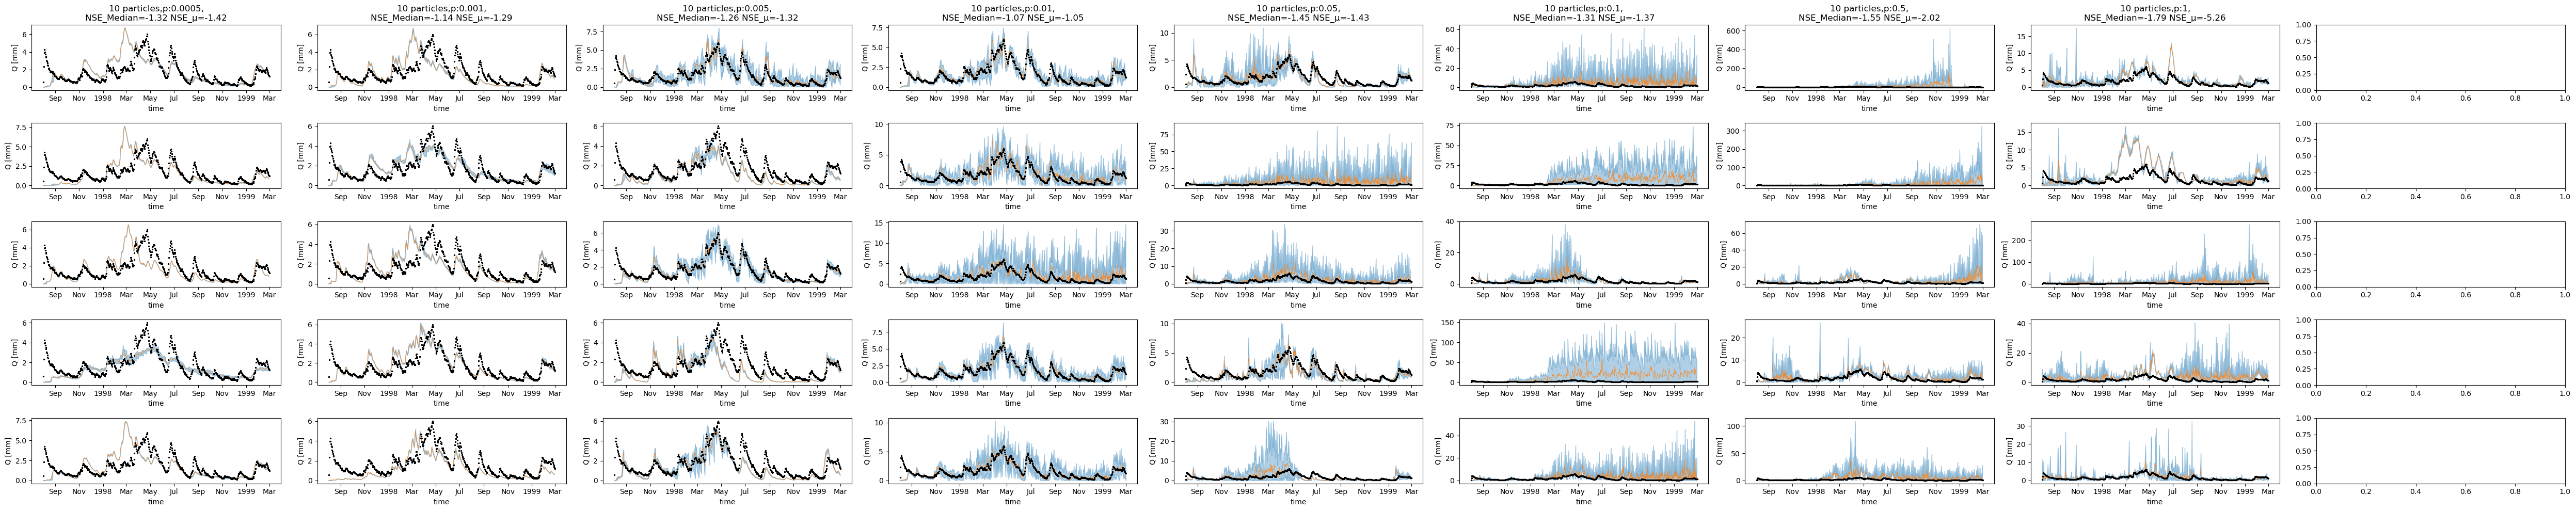

In [40]:
fig, axs = plt.subplots(n_iters, m_vars,figsize=(50,10))
spinup = 100
fig, axs = plot_itterations(m_vars-1, store_df, axs, spinup)

In [26]:
n_iters = 5
perturbation_sigma_lst = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]
m_vars = len(perturbation_sigma_lst)

# Using results: tune in on expected values

In [46]:
n_iters = 5
perturbation_sigma_lst = [ 0.005,0.006,0.007,0.008,0.009, 0.01]
m_vars = len(perturbation_sigma_lst)

In [47]:
store_df  = []
store_ds = []
for perturbation_sigma in perturbation_sigma_lst:
    lst_ds = []
    lst_df = []
    for i in range(n_iters):
        weight_sigma = 0.5
        n_particles = 10
    
        n_particles = 50
        ensemble = DA.Ensemble(N=n_particles)
        ensemble.setup()
        
        array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
        p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)
        
        # values wihch you 
        setup_kwargs_lst = []
        for index in range(n_particles):
            setup_kwargs_lst.append({'parameters':','.join([str(p) for p in p_intial[index]]), 
                                    'initial_storage':','.join([str(s) for s in s_0]),
                                     })
        
        ensemble.loaded_models.update({'HBVLocal': HBVLocal})
        
        # this initializes the models for all ensemble members. 
        ensemble.initialize(model_name=["HBVLocal"]*n_particles,
                            forcing=[camels_forcing]*n_particles,
                            setup_kwargs=setup_kwargs_lst) 
        
        lst_like_sigma = [perturbation_sigma] * 14 + [0]
        hyper_parameters = {'like_sigma_weights' : weight_sigma,
                            'like_sigma_state_vector' : lst_like_sigma,
                           }
        
        ensemble.initialize_da_method(ensemble_method_name = "PF", 
                                      hyper_parameters=hyper_parameters,                           
                                      state_vector_variables = "all", # the next three are keyword arguments but are needed. 
                                      observation_path = ds_obs_dir,
                                      observed_variable_name = "Q",
                                      measurement_operator = H, 
                                   
                                    )
        
        ref_model = ensemble.ensemble_list[0].model
        
        n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)
        
        time = []
        assimilated_times = []
        lst_state_vector = []
        lst_Q_prior = []
        lst_Q_obs = []
        lst_Q = [] 
        for i in tqdm(range(n_timesteps)):    
            time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
            lst_Q_prior.append(ensemble.get_value("Q").flatten())
            # update every 3 steps 
            if i % 3 == 0: 
                assimilate = True 
                assimilated_times.append(pd.Timestamp(ref_model.time_as_datetime.date()))
            else:
                assimilate = False
            ensemble.update(assimilate=assimilate)
             
            lst_state_vector.append(ensemble.get_state_vector())
            lst_Q.append(ensemble.get_value("Q").flatten())
            lst_Q_obs.append(ensemble.ensemble_method.obs)
        
        # end model - IMPORTANT! when working with dockers
        ensemble.finalize()
        
        Q_m_arr = np.array(lst_Q).T
        Q_m_arr_prior = np.array(lst_Q_prior).T
        state_vector_arr = np.array(lst_state_vector)
        
        save, load = False, False 
        current_time = str(datetime.now())[:-10].replace(":","_")
        
        if not load:
            df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])
            df_ensemble_prior = pd.DataFrame(data=Q_m_arr_prior[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])
        
            data_vars = {}
            for i, name in enumerate(param_names + stor_names+ ["Q"]):
                storage_terms_i = xr.DataArray(state_vector_arr[:,:,i].T,
                                               name=name,
                                               dims=["EnsembleMember","time"],
                                              coords=[np.arange(n_particles),df_ensemble.index],
                                              attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                                       "history": f"Storage term results from ewatercycle_HBV.model",
                                                    "description":"Moddeled values",
                                                         "units": "mm"})
                data_vars[name] = storage_terms_i
        
            ds_combined = xr.Dataset(data_vars,
                                     attrs={"title": f"HBV storage terms data over time for {n_particles} particles ", 
                                            "history": f"Storage term results from ewatercycle_HBV.model",}
                                      )
        lst_ds.append(ds_combined)
        lst_df.append(df_ensemble)
    store_ds.append(lst_ds)
    store_df.append(lst_df)

100%|█████████████████████████████████████████████████████████████████████████████████| 577/577 [02:42<00:00,  3.55it/s]


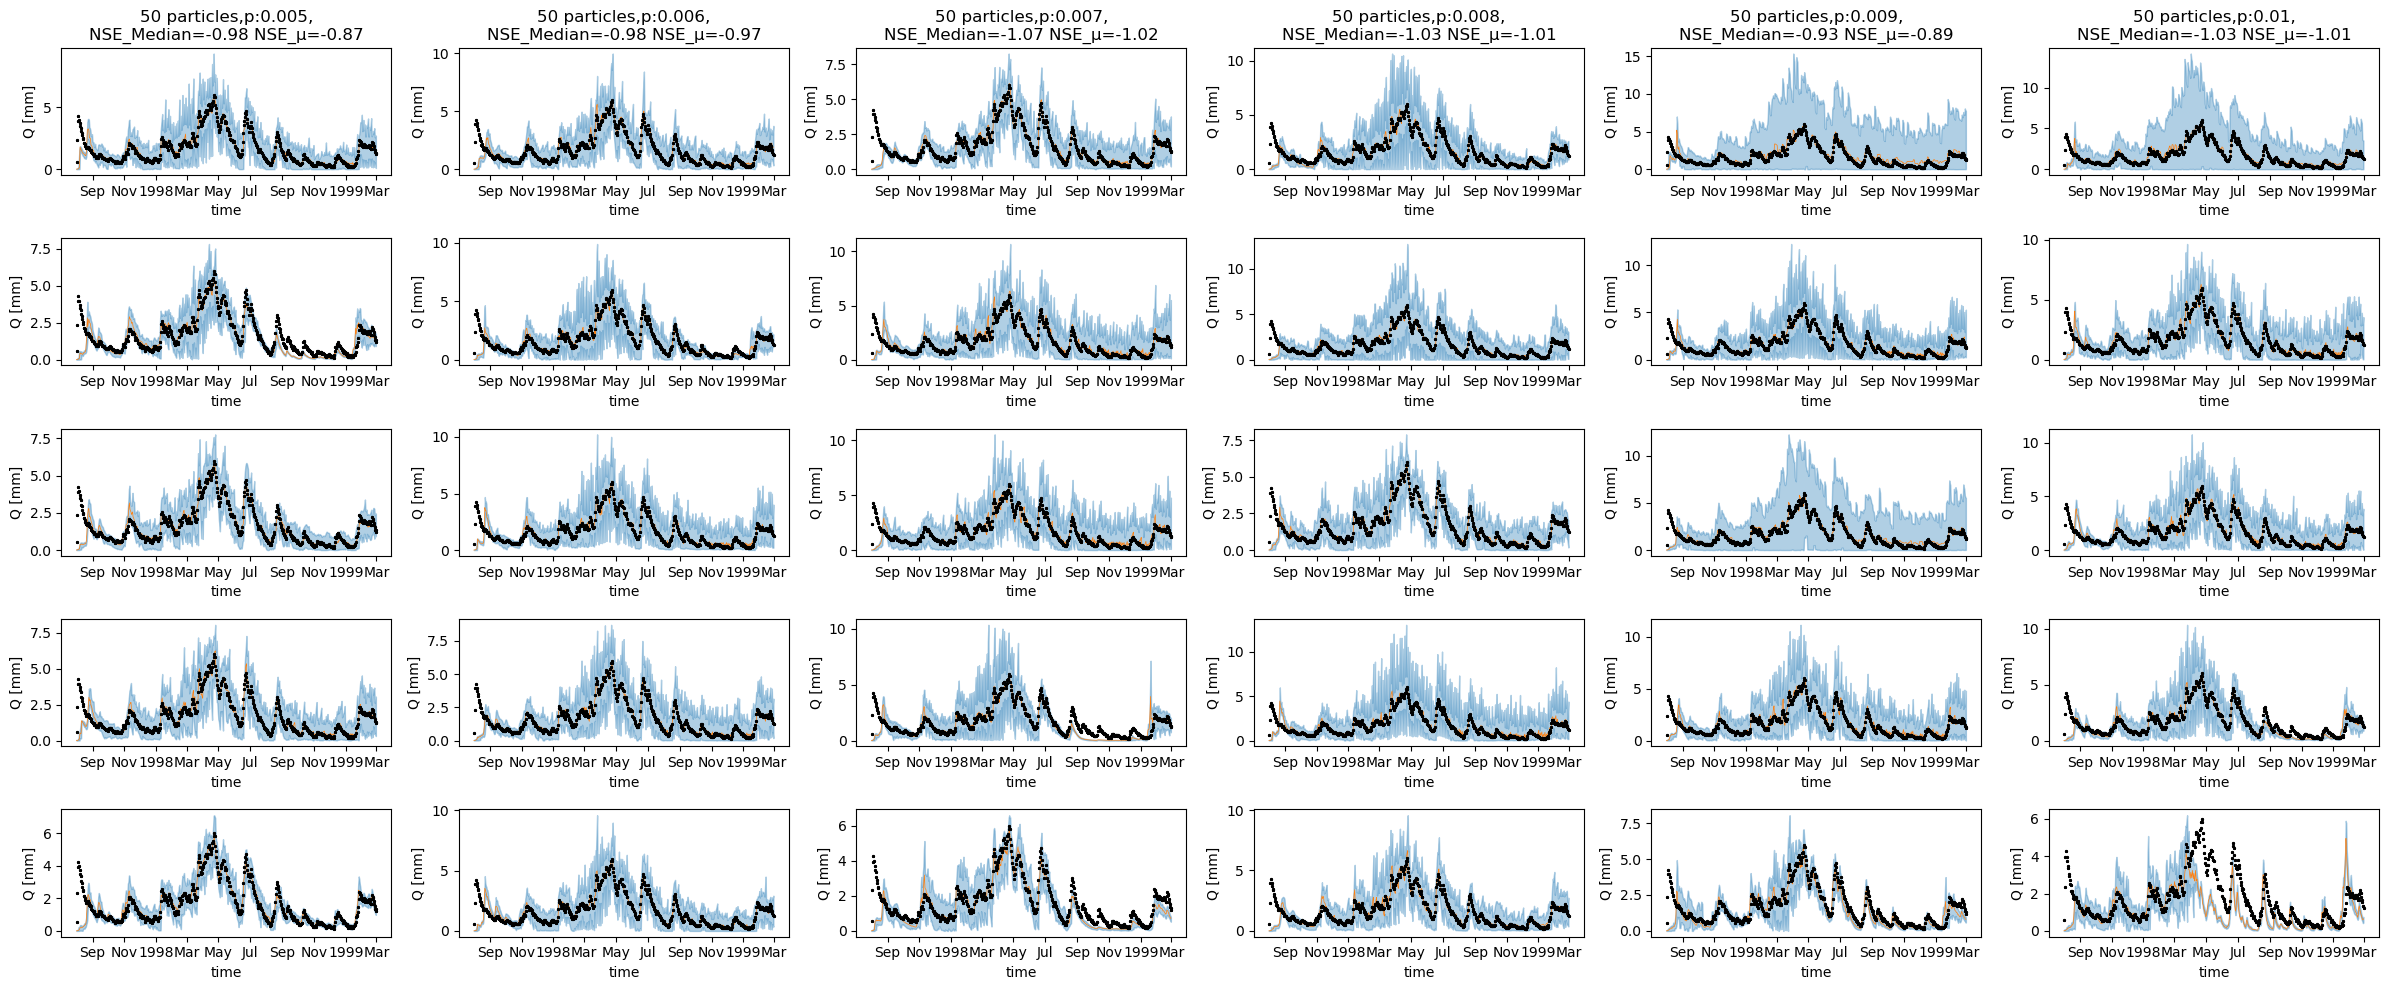

In [49]:
fig, axs = plt.subplots(n_iters, m_vars,figsize=(24,10))
spinup = 100
fig, axs = plot_itterations(m_vars, store_df, axs, spinup)